In [1]:
# Imports
import numpy as np
import pandas as pd
from collections import Counter 

#visual
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as mno

#learning
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, \
BayesianRidge, LogisticRegression
from sklearn.svm import LinearSVC


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

## Getting to Know the Data

In [2]:
# Loading data as pandas dataframe

# Naming the columns with attributes they represent
names = ['account_status', 'duration', 'credit_history',
             'purpose', 'credit_amount', 'savings_account', 'employment_since',
             'installment_rate', 'personal_status_sex', 'guarantors', 
             'residence_since', 'property', 'age', 'other_installment_plans',
             'housing', 'number_of_credits', 'job', 'people_to_maintain',
             'phone', 'foreign_worker', 'creditworthy']

df = pd.read_csv('data/kredit.dat', header=None, sep="\t", names=names)
# df = pd.read_csv('data/einkommen.train.txt', header=None, sep=",")
df.shape

(1000, 21)

In [3]:
# Last column is the target variable
df.creditworthy.replace([1,2], [1,0], inplace=True)
label = df['creditworthy']
df = df.drop(columns=['creditworthy'])
df.shape

(1000, 20)

In [4]:
# Getting familiar with data

print(f'Number of data points: {df.shape[0]}')
print(f'Number of Attributes: {df.shape[1]}')
df.head(5)

Number of data points: 1000
Number of Attributes: 20


,account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,guarantors,residence_since,property,age,other_installment_plans,housing,number_of_credits,job,people_to_maintain,phone,foreign_worker
0,A14,36,A32,?,2299,A63,?,4,A93,A101,4,A123,39,A143,A152,1,A173,1,A191,?
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,4,A124,61,A143,A153,1,?,1,A191,A201
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,3,A124,38,A141,A153,1,?,2,A191,?
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,3,A121,33,A141,A152,2,A173,1,A191,A201
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,3,A123,34,A143,A152,1,A173,2,A192,A201


In [5]:
print(df.dtypes)

# As we see above: 2 data types
# Features will be treated separately

categorical = [att for att in df.columns if df[att].dtype == 'object']
numerical = [att for att in df.columns if df[att].dtype == 'int64']

print(f'Categorical features:\n{categorical}\n')
print(f'Numerical features:\n{numerical}')

account_status             object
duration                    int64
credit_history             object
purpose                    object
credit_amount               int64
savings_account            object
employment_since           object
installment_rate            int64
personal_status_sex        object
guarantors                 object
residence_since             int64
property                   object
age                         int64
other_installment_plans    object
housing                    object
number_of_credits           int64
job                        object
people_to_maintain          int64
phone                      object
foreign_worker             object
dtype: object
Categorical features:
['account_status', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'guarantors', 'property', 'other_installment_plans', 'housing', 'job', 'phone', 'foreign_worker']

Numerical features:
['duration', 'credit_amount', 'installment_rate', 'resi

### How balanced is the dataset?

In [6]:
# 1 = good, trustworthy
# 0 = bad, Not trustworthy
print(label.value_counts())

# label.value_counts().plot(kind='bar', label= 'Target Values')
# There are more than twice as many creditworthy examples

# As we see, the scales are very different, so we will have to normalize the data
# df.hist(figsize = (20,13))

1    700
0    300
Name: creditworthy, dtype: int64


Problematic: It is more important for us to recognise the untrustworthy, but we have less data for them

In [7]:
# Change a yes/no categorical varibable into numeric one
df.replace('A201', 1, inplace=True)
df.replace('A202', 0, inplace=True)
df.replace('A191', 0, inplace=True)
df.replace('A192', 1, inplace=True)

#Rescale
df.credit_amount = np.log(df.credit_amount)

In [8]:
# Ranges of values 
print()
for pos in range(len(numerical)):
    print(f'{numerical[pos]} : {df[numerical[pos]].min()} - {df[numerical[pos]].max()}')


duration : 4 - 72
credit_amount : 5.521460917862246 - 9.82140944150052
installment_rate : 1 - 4
residence_since : 1 - 4
age : 19 - 75
number_of_credits : 1 - 4
people_to_maintain : 1 - 2


### 2.2 Handling Missing Values

NaN in Pandas:
1. Nan != NaN (whereas None == None)  
2. When summing data, NaN values will be treated as zero.   
If the data are all NA, the result will be 0.  



In [9]:
# For more convenient operations for missing values, replace ? with NaN
# As we see, there are too many missing values to remove these points from the dataset
df.replace("?", np.nan, inplace=True)

In [10]:
print(f'Number of Missing Values:\n\n{df.isnull().sum()}')

Number of Missing Values:

account_status               0
duration                     0
credit_history               0
purpose                    173
credit_amount                0
savings_account              0
employment_since           496
installment_rate             0
personal_status_sex          0
guarantors                   0
residence_since              0
property                     0
age                          0
other_installment_plans      0
housing                      0
number_of_credits            0
job                        232
people_to_maintain           0
phone                        0
foreign_worker             360
dtype: int64


In [11]:
missing_columns = ['purpose', 'employment_since', 'job', 'foreign_worker']

In [12]:
# Percentage of missing values
df[missing_columns].isnull().sum()/len(df)

purpose             0.173
employment_since    0.496
job                 0.232
foreign_worker      0.360
dtype: float64

Purpose - 17.3%.   
Employment since - 49.6%  
job - 0.23%.   
foreign worker - 36%. 

?? Drop Employment_since all together?

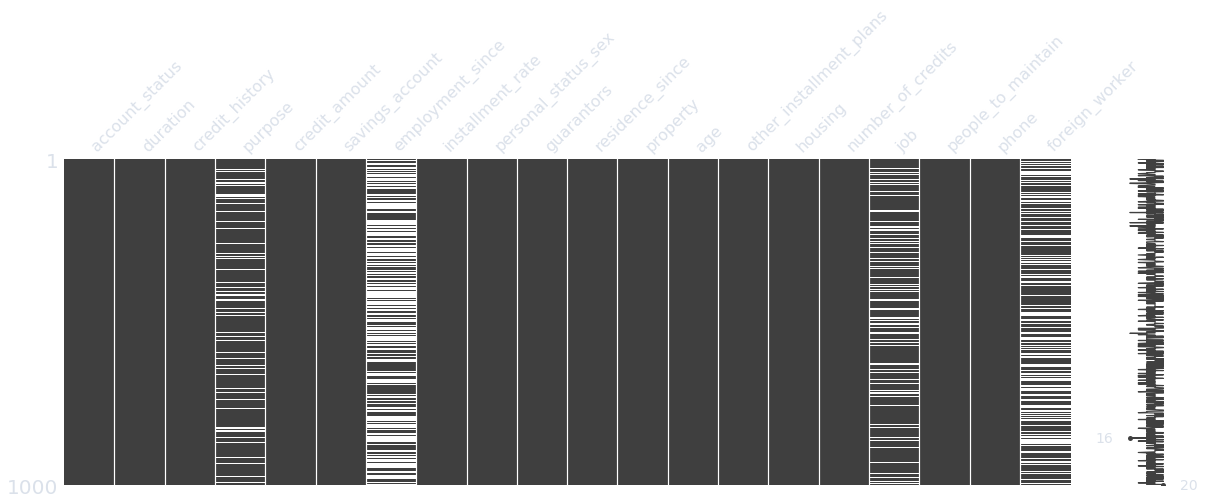

In [13]:
mno.matrix(df, figsize = (20, 6))

In [14]:
# Check out data points where purpose is missing
#df[df.purpose.isnull()]

In [15]:
# Show how many unique categorical values we have: useful for one-hot encoding
df[categorical].nunique()

account_status              4
credit_history              5
purpose                    10
savings_account             5
employment_since            5
personal_status_sex         4
guarantors                  3
property                    4
other_installment_plans     3
housing                     3
job                         4
phone                       2
foreign_worker              2
dtype: int64

In [16]:
pd.crosstab(label, df['credit_history'])

credit_history,A30,A31,A32,A33,A34
creditworthy,,,,,
0,25,28,169,28,50
1,15,21,361,60,243


There are many options we could consider when replacing a missing value, for example:

- A constant value that has meaning within the domain, such as 0, distinct from all other values.  
- A value from another randomly selected record.  
- A mean, median or mode value for the column.  
- A value estimated by another predictive model. 

Imputation with Regression
This is an imputation technique that uses information from the observed data to replace the missing values with predicted values from a regression model. The major drawback of using this method is that it reduces variability and overestimates the model fit and correlation coefficient.

Prediction model is one of the sophisticated method for handling missing data. Here, we create a predictive model to estimate values that will substitute the missing data.  In this case, we divide our data set into two sets: One set with no missing values for the variable and another one with missing values. First data set become training data set of the model while second data set with missing values is test data set and variable with missing values is treated as target variable. Next, we create a model to predict target variable based on other attributes of the training data set and populate missing values of test data set.

In [17]:
print(df.shape)
# Dropping not an option: too much data lost
print(df.dropna().shape)
#no data points withh all values missing
print(df.dropna(how='all').shape)
# ?? maybe it makes sense to remove data points with many missing things
print(df.dropna(subset=['purpose', 'foreign_worker', 'employment_since'], how='all').shape)
# print(df.purpose.value_counts(dropna=False))

(1000, 20)
(203, 20)
(1000, 20)
(969, 20)


### Imputation

When we have multiple variables with missing values, we can't just directly use Regression Imputation to impute one of them as the predictors contain missing data themselves. But then, how can we impute one variable without imputing another?

We can avoid this Catch-22 situation by initially imputing all the variables with missing values using some trivial methods like Simple Random Imputation (we impute the missing data with random observed values of the variable) which is later followed by Regression Imputation of each of the variables iteratively.

## 2. Data Pre-Processing

### 2.1 Feature Representation

#### 2.1.1 Numerical

In [18]:
# Normalize all numerical attributes
def zscore(x):
    #assert isinstance(x,np.ndarray), "x must be a numpy array"
    return (x-np.mean(x)) / np.std(x)

df = df.apply(lambda x: zscore(x) if x.dtype == 'int64' else x)
# df.hist(figsize = (20,13))
df.head()

,account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,guarantors,residence_since,property,age,other_installment_plans,housing,number_of_credits,job,people_to_maintain,phone,foreign_worker
0,A14,1.252574,A32,NaN,7.740230,A63,NaN,0.918477,A93,A101,1.046987,A123,0.303788,A143,A152,-0.704926,A173,-0.428290,-0.823318,NaN
1,A12,-0.240857,A32,A46,7.122060,A65,A73,0.918477,A93,A101,1.046987,A124,2.238742,A143,A153,-0.704926,NaN,-0.428290,-0.823318,1.0
2,A13,0.256953,A32,A40,6.853299,A61,A74,0.918477,A93,A101,0.140505,A124,0.215835,A141,A153,-0.704926,NaN,2.334869,-0.823318,NaN
3,A14,-0.489762,A33,A43,7.298445,A61,A73,0.918477,A94,A101,0.140505,A121,-0.223927,A141,A152,1.027079,A173,-0.428290,-0.823318,1.0
4,A14,0.256953,A32,A40,7.329750,A64,A74,0.918477,A92,A101,0.140505,A123,-0.135974,A143,A152,-0.704926,A173,2.334869,1.214598,1.0


#### 2.1.2 Categorical


In [19]:
# Columns without missing values = X, columns with missing values become y one by one

In [20]:
# Feature representation

print("Unique categorical values:")
for att in df.select_dtypes(include=[object]):
    print(att,":", df[att].unique())
    
# We will have to represent features differently 

Unique categorical values:
account_status : ['A14' 'A12' 'A13' 'A11']
credit_history : ['A32' 'A33' 'A34' 'A30' 'A31']
purpose : [nan 'A46' 'A40' 'A43' 'A41' 'A42' 'A49' 'A410' 'A45' 'A48' 'A44']
savings_account : ['A63' 'A65' 'A61' 'A64' 'A62']
employment_since : [nan 'A73' 'A74' 'A75' 'A72' 'A71']
personal_status_sex : ['A93' 'A94' 'A92' 'A91']
guarantors : ['A101' 'A102' 'A103']
property : ['A123' 'A124' 'A121' 'A122']
other_installment_plans : ['A143' 'A141' 'A142']
housing : ['A152' 'A153' 'A151']
job : ['A173' nan 'A174' 'A172' 'A171']


In [21]:
# which nominal columns to encode as onehot vectors for impution: 
# inly nominal categories without missing values
to_onehot = [el for el in categorical if el not in missing_columns]
to_onehot

['account_status',
 'credit_history',
 'savings_account',
 'personal_status_sex',
 'guarantors',
 'property',
 'other_installment_plans',
 'housing',
 'phone']

In [22]:
# print(f'old categorical variables: {categorical} \n')
# 1-hot encoding for the categorical variables
df_only_one_hot = pd.get_dummies(df[to_onehot])
print('new 1-hot-encoded variables: {}'.format(list(df_only_one_hot.columns)))
# we get rid of the redundant columns:
# df_one_hot.drop(labels=[''], axis=1, inplace=True)

new 1-hot-encoded variables: ['phone', 'account_status_A11', 'account_status_A12', 'account_status_A13', 'account_status_A14', 'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'savings_account_A61', 'savings_account_A62', 'savings_account_A63', 'savings_account_A64', 'savings_account_A65', 'personal_status_sex_A91', 'personal_status_sex_A92', 'personal_status_sex_A93', 'personal_status_sex_A94', 'guarantors_A101', 'guarantors_A102', 'guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installment_plans_A141', 'other_installment_plans_A142', 'other_installment_plans_A143', 'housing_A151', 'housing_A152', 'housing_A153']


In [23]:
# Concatenate numerical and categorical data
df_with_onehot = pd.concat([df[numerical], df_only_one_hot], axis = 1)

In [24]:
# train columns to use for impution
df_with_onehot.shape

(1000, 39)

In [25]:
# Ready for Random Forest
df_with_onehot.head()

,duration,credit_amount,installment_rate,residence_since,age,number_of_credits,people_to_maintain,phone,account_status_A11,account_status_A12,...,property_A121,property_A122,property_A123,property_A124,other_installment_plans_A141,other_installment_plans_A142,other_installment_plans_A143,housing_A151,housing_A152,housing_A153
0,1.252574,7.740230,0.918477,1.046987,0.303788,-0.704926,-0.428290,-0.823318,0,0,...,0,0,1,0,0,0,1,0,1,0
1,-0.240857,7.122060,0.918477,1.046987,2.238742,-0.704926,-0.428290,-0.823318,0,1,...,0,0,0,1,0,0,1,0,0,1
2,0.256953,6.853299,0.918477,0.140505,0.215835,-0.704926,2.334869,-0.823318,0,0,...,0,0,0,1,1,0,0,0,0,1
3,-0.489762,7.298445,0.918477,0.140505,-0.223927,1.027079,-0.428290,-0.823318,0,0,...,1,0,0,0,1,0,0,0,1,0
4,0.256953,7.329750,0.918477,0.140505,-0.135974,-0.704926,2.334869,1.214598,0,0,...,0,0,1,0,0,0,1,0,1,0


In [26]:
# these columns will be target values, one by one.
# df[missing_columns].head()

### Evaluation

Aim: how many people out of those who thought werr trustworthy, were actually trustworthy

Aim: reduce the FP number, to increase precision  
Note: A model that produces no false positives has a precision of 1.0.

![]()

In [27]:
# Function for evaluation reports

def evaluate(clf, X_train, y_train):
    ''' 10-fold Cross Validation on training and validation data 
        Nothing to return '''

    metrics = ['accuracy', 'f1_micro']
    for metric in metrics: 
        scores = cross_val_score(clf, X_train, y_train, cv=10, scoring=metric)
        
        # The mean score and standard deviation of the score estimate
        print("Cross Validation %s: %0.2f (+/- %0.2f)" % (metric, scores.mean(), scores.std()))
    
    return 


def predict(clf, X_train, y_train, X_test):    
    ''' Predict on unseen test data 
        Return predicted labels '''
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return y_pred

def evaluate_test(y_pred, y_test):
    print(f'Test Precision Score: {precision_score(y_test, y_pred)}')
    print(f'Test Accuracy Score: {accuracy_score(y_test, y_pred)}')
    return 


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization by class can be applied by setting `normalize=True`.
    This kind of normalization can be interesting in case of class
    imbalance to have a more visual interpretation of which class is being misclassified.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Random Forest

Random forest classifier creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object.

In [28]:
# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(df_with_onehot, label, 
                                                    test_size = 0.25, random_state=4)

In [29]:
def randomforestclf_benchmark(X_train, y_train, X_test, y_test):

    print("RandomForestClassifier: Benchmark")
    
    #Train and validate: Cross-validation
    print("RandomForestClassifier")
    n_trees = [1,5,10,50,100]
    
    for num_of_trees in n_trees:
        print(f'\nRandom Forest with {num_of_trees} trees: ')
        randomforest = RandomForestClassifier(n_estimators=num_of_trees)
        evaluate(randomforest, X_train, y_train)
        y_pred = predict(randomforest, X_train, y_train, X_test)
        evaluate_test(y_pred, y_test)
    
#         tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#         print(f'Test Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')
#         print(f'False Positives: {fp}')
    


In [30]:
# Random Forest: Benchmark

def randomforestclf_grid_search(X_train, y_train, X_test, y_test):
    
    #Seting the Hyper Parameters
    param_grid = {"max_depth": [3, 5, 7, 10, 20, None],
                  "n_estimators":[1, 10, 50, 150],
                  "max_features": [1, 10, 20, "auto"],
                  "criterion" : ['gini','entropy']}

    #Creating the classifier
    model = RandomForestClassifier(random_state=33)

    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='precision', verbose=1)
    grid_search.fit(X_train, y_train)
    
    print(f'Best Score: {grid_search.best_score_}')
    print(grid_search.best_params_)
    #let's see the best estimator
    print(f'Best Estimator: \n {grid_search.best_estimator_}')

    return


In [31]:
randomforestclf_benchmark(X_train, y_train, X_test, y_test)

RandomForestClassifier: Benchmark
RandomForestClassifier

Random Forest with 1 trees: 
Cross Validation accuracy: 0.65 (+/- 0.06)
Cross Validation f1_micro: 0.64 (+/- 0.05)
Test Precision Score: 0.7486033519553073
Test Accuracy Score: 0.656

Random Forest with 5 trees: 
Cross Validation accuracy: 0.74 (+/- 0.06)
Cross Validation f1_micro: 0.71 (+/- 0.04)
Test Precision Score: 0.7842105263157895
Test Accuracy Score: 0.732

Random Forest with 10 trees: 
Cross Validation accuracy: 0.72 (+/- 0.04)
Cross Validation f1_micro: 0.73 (+/- 0.04)
Test Precision Score: 0.782608695652174
Test Accuracy Score: 0.716

Random Forest with 50 trees: 
Cross Validation accuracy: 0.76 (+/- 0.04)
Cross Validation f1_micro: 0.76 (+/- 0.03)
Test Precision Score: 0.7718446601941747
Test Accuracy Score: 0.748

Random Forest with 100 trees: 
Cross Validation accuracy: 0.75 (+/- 0.03)
Cross Validation f1_micro: 0.77 (+/- 0.04)
Test Precision Score: 0.7821782178217822
Test Accuracy Score: 0.756


In [32]:
# randomforestclf_grid_search(X_train, y_train, X_test, y_test)

In [33]:
def best_randomforest():

    randomforest = RandomForestClassifier(n_estimators=10, criterion='gini',
                                         max_features=20,max_depth=20)
    evaluate(randomforest, X_train, y_train)
    y_pred = predict(randomforest, X_train, y_train, X_test)
    evaluate_test(y_pred, y_test)
    
    return

In [34]:
best_randomforest()

Cross Validation accuracy: 0.74 (+/- 0.04)
Cross Validation f1_micro: 0.73 (+/- 0.05)
Test Precision Score: 0.8135593220338984
Test Accuracy Score: 0.744


### Handling missing Values

In [35]:
# Three Nominal values and one numeric 1/0 value
df[missing_columns].dtypes

purpose              object
employment_since     object
job                  object
foreign_worker      float64
dtype: object

In [36]:
def encode_target_var(y_train, method = 'categorical', verbose=False):
    ''' Encode the y label with a specified method''' 
    
    if method == 'categorical':
        enc = LabelEncoder()
        y_train = enc.fit_transform(y_train)
        if verbose: 
            print('\nCategorical encoding of y label. Classes: ', list(enc.classes_))
    elif method == 'one-hot':
#         y_train = pd.get_dummies(y_train)
        enc = LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
        y_train = enc.fit_transform(y_train)
        print(y_train)
        if verbose: 
            print('One-hot-encoding of y label. Classes: {}', list(enc.classes_))
    elif method == 'none':
        pass
        
    return y_train


def split_data_missing_vals(data, target_col, encoding_method='none', verbose=False):
    ''' Split data into training and test datasets. 
    Test data: missing value in column,
    train data: existing data  
    
    Return 1) x_train with y column in it
        2) x_train withought y_column
        3) y_train
        4) x_test'''
    
    concat_df_target_col = pd.concat([data, df[target_col]], axis=1)

    #Select only the rows where the target label is NaN
    target_x_test = concat_df_target_col[(
        concat_df_target_col[target_col].isna())]
    # original: df with target column in it
    target_x_train_orig = concat_df_target_col[(
        concat_df_target_col[target_col].notna())]

    if verbose:
        print('Numer of test data points: ', target_x_test.shape[0])
        print('Numer of train data points: ', target_x_train_orig.shape[0])

    # Separate the y label
    target_y_train = target_x_train_orig[target_col]

    # Remove the y column from the df
    target_x_test = target_x_test.drop([target_col], axis=1)
    target_x_train = target_x_train_orig.drop([target_col], axis=1)
    
    #Encode target variable
#     target_y_train = encode_target_var(target_y_train, encoding_method, verbose=True)

    return target_x_train_orig, target_x_train, target_y_train, target_x_test



In [37]:
def compare_classifiers(classifiers, classifier_names, missing_columns, data, \
                        encoding_method='categorical', verbose=False):

    for col in missing_columns:
        print('\n================================= \n')
        print(f'Linear Classification for featuren "{col}"')

        # Split data. Test data: missing value in column, train data: existing data 
        target_x_train_orig, target_x_train, target_y_train, target_x_test = split_data_missing_vals(
            data, col)

        for clf, name in zip(classifiers, classifier_names): 
            print(f'\nClassifier: {name} \n')

            # evaluate and predict
            evaluate(clf, target_x_train, target_y_train)
            y_pred = predict(clf, target_x_train, target_y_train, target_x_test)
    return

In [38]:
# Inherently multiclass: RidgeClassifier()
# Multiclass as One-Vs-All: SGDClassifier(), PassiveAggressiveClassifier()
# https://scikit-learn.org/stable/modules/multiclass.html
classifiers = [SGDClassifier(), RidgeClassifier(), PassiveAggressiveClassifier(), \
              LogisticRegression()]
classifier_names = ['SGDClassifier', 'RidgeClassifier', 'PassiveAggressiveClassifier', \
                   'LogisticRegression']
missing_columns = ['purpose', 'employment_since', 'job', 'foreign_worker']
data = df_with_onehot
encoding_methods = ['categorical', 'one-hot']

In [39]:
compare_classifiers(classifiers, classifier_names, missing_columns, data, encoding_method='none')



Linear Classification for featuren "purpose"

Classifier: SGDClassifier 

Cross Validation accuracy: 0.25 (+/- 0.04)
Cross Validation f1_micro: 0.25 (+/- 0.05)

Classifier: RidgeClassifier 

Cross Validation accuracy: 0.34 (+/- 0.06)
Cross Validation f1_micro: 0.34 (+/- 0.06)

Classifier: PassiveAggressiveClassifier 

Cross Validation accuracy: 0.22 (+/- 0.05)
Cross Validation f1_micro: 0.25 (+/- 0.04)

Classifier: LogisticRegression 

Cross Validation accuracy: 0.34 (+/- 0.05)
Cross Validation f1_micro: 0.34 (+/- 0.05)


Linear Classification for featuren "employment_since"

Classifier: SGDClassifier 

Cross Validation accuracy: 0.37 (+/- 0.06)
Cross Validation f1_micro: 0.28 (+/- 0.07)

Classifier: RidgeClassifier 

Cross Validation accuracy: 0.39 (+/- 0.05)
Cross Validation f1_micro: 0.39 (+/- 0.05)

Classifier: PassiveAggressiveClassifier 

Cross Validation accuracy: 0.29 (+/- 0.08)
Cross Validation f1_micro: 0.29 (+/- 0.09)

Classifier: LogisticRegression 

Cross Validation accu

Only classification of "foreign_worker" performs well enough to use it to fill the missing values.

In [53]:
def create_predicted_column(clf, data, col): 
    ''' Args: 
    clf: classifier used for prediction
    data: dataframe
    col: name of column to predict
    
    Return 1) predicted column
            2) dataframe with inserted predicted column'''
    
    
    target_x_train_orig, target_x_train, target_y_train, target_x_test = split_data_missing_vals(
            data, col)
    y_pred = predict(clf, target_x_train, target_y_train, target_x_test)
    # Fill NAs with predicted values
    target_x_test[col] = y_pred
    
    # Concat training and test rows
    df_filled_foreign_w = pd.concat([target_x_train_orig, target_x_test], axis=0)
    df_filled_foreign_w = df_filled_foreign_w.sort_index()
    return df_filled_foreign_w[col], df_filled_foreign_w
    

In [55]:
col_foreign_w, df_filled_foreign_w = create_predicted_column(
    RidgeClassifier(), df_with_onehot, "foreign_worker")

In [51]:
# 5 rows × 39 columns
df_with_onehot.head()


,duration,credit_amount,installment_rate,residence_since,age,number_of_credits,people_to_maintain,phone,account_status_A11,account_status_A12,...,property_A121,property_A122,property_A123,property_A124,other_installment_plans_A141,other_installment_plans_A142,other_installment_plans_A143,housing_A151,housing_A152,housing_A153
0,1.252574,7.740230,0.918477,1.046987,0.303788,-0.704926,-0.428290,-0.823318,0,0,...,0,0,1,0,0,0,1,0,1,0
1,-0.240857,7.122060,0.918477,1.046987,2.238742,-0.704926,-0.428290,-0.823318,0,1,...,0,0,0,1,0,0,1,0,0,1
2,0.256953,6.853299,0.918477,0.140505,0.215835,-0.704926,2.334869,-0.823318,0,0,...,0,0,0,1,1,0,0,0,0,1
3,-0.489762,7.298445,0.918477,0.140505,-0.223927,1.027079,-0.428290,-0.823318,0,0,...,1,0,0,0,1,0,0,0,1,0
4,0.256953,7.329750,0.918477,0.140505,-0.135974,-0.704926,2.334869,1.214598,0,0,...,0,0,1,0,0,0,1,0,1,0


In [50]:
# 5 rows × 40 columns
df_filled_foreign_w.head()

,duration,credit_amount,installment_rate,residence_since,age,number_of_credits,people_to_maintain,phone,account_status_A11,account_status_A12,...,property_A122,property_A123,property_A124,other_installment_plans_A141,other_installment_plans_A142,other_installment_plans_A143,housing_A151,housing_A152,housing_A153,foreign_worker
0,1.252574,7.740230,0.918477,1.046987,0.303788,-0.704926,-0.428290,-0.823318,0,0,...,0,1,0,0,0,1,0,1,0,1.0
1,-0.240857,7.122060,0.918477,1.046987,2.238742,-0.704926,-0.428290,-0.823318,0,1,...,0,0,1,0,0,1,0,0,1,1.0
2,0.256953,6.853299,0.918477,0.140505,0.215835,-0.704926,2.334869,-0.823318,0,0,...,0,0,1,1,0,0,0,0,1,1.0
3,-0.489762,7.298445,0.918477,0.140505,-0.223927,1.027079,-0.428290,-0.823318,0,0,...,0,0,0,1,0,0,0,1,0,1.0
4,0.256953,7.329750,0.918477,0.140505,-0.135974,-0.704926,2.334869,1.214598,0,0,...,0,1,0,0,0,1,0,1,0,1.0


### Multiclass classifiers

## Feature Reduction

### Covariance Matrix between features

In [44]:
# df_drop_cols = df.drop(missing_columns, axis=1)
#df_drop_cols.isna().sum()
# print(df_drop_cols.shape)
# print(label.shape)

# #Encode categorical labels (excluded missisng columns)
# label_encoder = LabelEncoder()
# label_encoded_data = df[to_onehot].apply(lambda x: d[x.name].fit_transform(x))
# # encoded_labels = label_encoder.fit_transform(df_drop_cols[to_onehot].columns)
# # print(encoded_labels)
# # print(label_encoder.inverse_transform(encoded_labels))

# for x in range(len(to_onehot)):
#     print(to_onehot[x], ': ', df[to_onehot[x]].unique())
#     print(to_onehot[x], ': ', label_encoded_data[to_onehot[x]].unique())

#         # Plot non-normalized confusion matrix
#     plot_confusion_matrix(y_test, y_pred, classes=y_test.unique(),
#                       title='Confusion matrix, without normalization')

#     # Plot normalized confusion matrix
#     plot_confusion_matrix(y_test, y_pred, classes=y_test.unique(), normalize=True,
#                       title='Normalized confusion matrix')